# Learning $\hat{\Omega}$

In this notebook, we're going to demonstrate parameter inference for $\Omega$, under the assumption that $\Omega$ depends only on subgroup sizes within each edge. We consider a scenario in which we already know or have a guess about $Z$. 

In [10]:
using StatsBase
using Combinatorics
using Plots

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/inference.jl");

First thing we'll do is define a set of parameters, including group memberships $Z$, degree parameters $\vartheta$, and the connection function $\Omega$. 

In [65]:
# parameters

n = 40
Z = rand(1:5, n)
ϑ = dropdims(ones(1,n) + rand(1,n), dims = 1)

# defining group intensity function Ω
μ = mean(ϑ)
fk = k->(2*μ*k)^(-k)
fp = harmonicMean
Ω = z->groupSizePartition(z, fp, fk); # depends only on the size of the hyperedge

#330 (generic function with 1 method)

Now we'll sample from the HSBM with these parameters

In [66]:
# sample from the HSBM with these parameters, restricting to hyperedges of size no more than kmax
kmax = 4
H = sampleSBM(Z, ϑ, Ω; kmax=kmax, kmin = 1)

hypergraph
  E: Dict{Integer,Dict}
  D: Dict{Integer,Integer}


Next, we'll use the function `estimateΩ` from `jl/inference.jl` to obtain an estimate $\hat{\Omega}$ of $\Omega$ from the realized data. We'll also "infer" $\vartheta$ from the data, although this is a trivial one-liner. 

In [67]:
ω̂ = estimateΩ(H, Z)
function Ω̂(z)
    p = -sort(-collect(values(countmap(vec(z)))))
    get(ω̂,p,0)
end

# technically, this counts as "inferring" ϑ under our normalization scheme. This is just the degree sequence. 
ϑ̂ = 1.0*[H.D[i] for i in 1:length(H.D)];

Now we can sample from the HSBM with the inferred parameters.

In [68]:
H_ = sampleSBM(Z, ϑ̂, Ω̂; kmax=kmax, kmin = 1)

hypergraph
  E: Dict{Integer,Dict}
  D: Dict{Integer,Integer}


In general, because of the identifiability issues between $\Omega$ and $\vartheta$, we shouldn't expect that $\hat{\Omega}$ is close to $\Omega$ or that $\hat{\vartheta}$ is close to $\vartheta$. However, we can reasonably expect that the associated distributions over hypergraphs are reasonably similar. We can illustrate that heuristically by comparing the degree and dimension sequences. 

In [69]:
d  = [H.D[i] for i in 1:length(H.D)]
d_ = [H_.D[i] for i in 1:length(H_.D)];

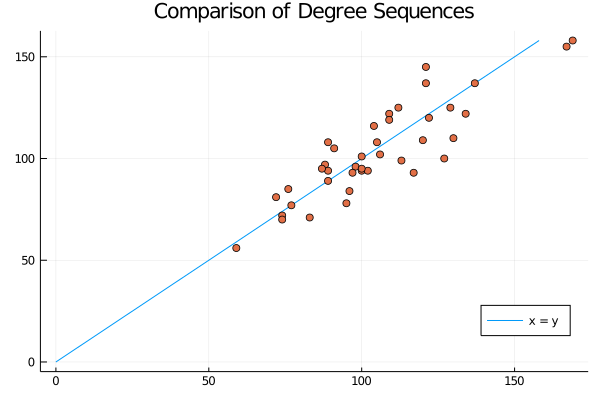

In [70]:
plot([0, maximum(d_)], [0, maximum(d_)], label= "x = y")
plot!(d, d_, seriestype = :scatter,label="", title = "Comparison of Degree Sequences", legend=:bottomright)

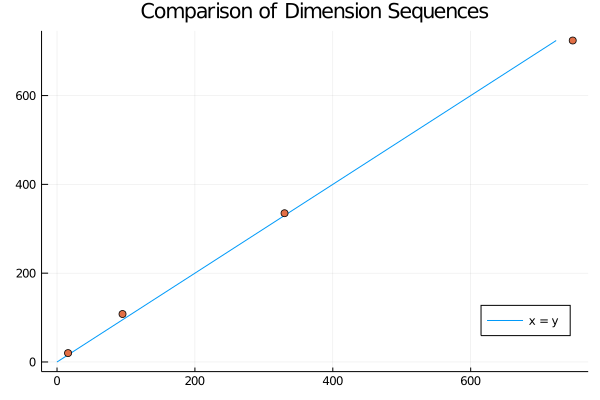

In [71]:
K  = [length(H.E[k]) for k in 1:maximum(keys(H.E))]
K_ = [length(H_.E[k]) for k in 1:maximum(keys(H_.E))]

plot([0, maximum(K_)], [0, maximum(K_)], label= "x = y")
plot!(K, K_, seriestype = :scatter,label="", title = "Comparison of Dimension Sequences", legend=:bottomright)

This is reasonable qualitative evidence that we are able to correctly learn $\Omega$ from data in this restricted case. 